In [1]:
# install necessary packages

using Pkg
Pkg.add(["Distributions","HDF5","Statistics","DataFrames","CSV","DataStructures","UpdateJulia","StatsBase","Shuffle","PyPlot"])
Pkg.update()
Pkg.build("PyCall")

using Statistics
using HDF5
using DataFrames
using Distributions
using DataStructures
using StatsBase
using CSV
using Shuffle
using Profile
using PyPlot

# check number of threads for parallelization
Threads.nthreads()

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
   Installed HDF5_jll ─ v1.14.3+1
  No Changes to `~/.julia/environments/v1.10/Project.toml`
    Updating `~/.julia/environments/v1.10/Manifest.toml`
  [0234f1f7] ↑ HDF5_jll v1.14.3+0 ⇒ v1.14.3+1
Precompiling project...
  ✓ HDF5_jll
  ✓ HDF5
  2 dependencies successfully precompiled in 7 seconds. 89 already precompiled.
    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/51cab8e982c5b598eea9c8ceaced4b58d9dd37c9/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/9816a3826b0ebf49ab4926e2b18842ad8b5c8f04/build.log`


8

In [2]:
# test cuda
# install the package
Pkg.add("CUDA")

# smoke test (this will download the CUDA toolkit)
using CUDA
CUDA.versioninfo()

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


CUDA toolkit 11.7, artifact installation
NVIDIA driver 545.29.2, for CUDA 12.3
CUDA driver 12.3

Libraries: 
- CUBLAS: 11.10.1
- CURAND: 10.2.10
- CUFFT: 10.7.2
- CUSOLVER: 11.3.5
- CUSPARSE: 11.7.3
- CUPTI: 17.0.0
- NVML: 12.0.0+545.29.2
- CUDNN: 8.30.2 (for CUDA 11.5.0)
- CUTENSOR: 1.4.0 (for CUDA 11.5.0)

Toolchain:
- Julia: 1.9.0
- LLVM: 14.0.6
- PTX ISA support: 3.2, 4.0, 4.1, 4.2, 4.3, 5.0, 6.0, 6.1, 6.3, 6.4, 6.5, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5
- Device capability support: sm_35, sm_37, sm_50, sm_52, sm_53, sm_60, sm_61, sm_62, sm_70, sm_72, sm_75, sm_80, sm_86

1 device:
  0: NVIDIA GeForce GTX 750 Ti (sm_50, 1.657 GiB / 2.000 GiB available)


In [2]:
# load latest algorithms
include("Benchmarks_dueling.jl")
include("dueling_algos.jl")

tune (generic function with 1 method)

In [3]:
# run bandit algorithms

# tuned params from cross-validation (see tune_nonstat_duel.jl)
current_params_m = [0.01, 0.001, 0.1, 1] 
current_params_a = [0.01, 0.1, 1] 
current_params_IF = [1] 

# set environment parameters
T = 50000 # horizon
K = 10 # number of arms
Episodes = [4] # number of stationary phases
N = 50 # number of trials
P = [] # array of preference matrices
winners=[] # array of winners in each stationary phase
for j=1:length(Episodes)
    P_j=[]
    winners_j=[]
    for i=1:N
        P_temp, winners_temp = geomBTL(T,K,Episodes[j],false) 
        push!(P_j,P_temp)
        push!(winners_j,winners_temp)
    end
    push!(P,P_j)
    push!(winners,winners_j)
end

# list of policies
policies= [RANDDUEL,IF,ANACONDA,METASWIFT]

saveRes = "on" # save results
series="geombtl"  # experiment save name
lP = length(policies)

# sub-sample the time
tsave=floor.(Int,collect(range(1,T,length=500)))'
ts = length(tsave)

# run algorithms on environments
for j=1:length(Episodes)
    for imeth in 1:lP
    	policy = policies[imeth]
    	# storing regret and restarts
    	Regret = zeros(N,ts)
    	Restarts = zeros(N)
        repTime = zeros(N)
        if (saveRes == "on")
            run(`mkdir results/$(series)_$(policy)_T_$(T)_N_$(N)_S_$(Episodes[j])`)
        end
    	Threads.@threads for n in 1:N
            ChangePoints=[] # store restart times of adaptive algorithms
            starttime = time() # for measuring runtime
    		if policy==RANDDUEL
                ChosenArms = RANDDUEL(P[j][n])
                ChangePoints=[]
    		elseif policy==EXP3SDuel
    			ChosenArms = EXP3SDuel(P[n],current_params_s)
                ChangePoints=[]
    		elseif policy==METASWIFT
                ChosenArms,ChangePoints =  METASWIFT(P[j][n],
                                                current_params_m,
                                                "off")  
            elseif policy==ANACONDA
    			ChosenArms,ChangePoints = ANACONDA(P[j][n],current_params_a,
                                                            "off") 
            elseif policy==IF
                ChosenArms = IF(P[j][n],current_params_IF[1],"off")
                ChangePoints=[]
    		end
    		reg = ComputeCumRegretDueling(P[j][n],ChosenArms,winners[j][n])
    		Regret[n,:]=vec(reg[tsave])
    		Restarts[n]=length(ChangePoints)
            name = "results/$(series)_$(policy)_T_$(T)_N_$(N)_S_$(Episodes[j])/$(n)"
            elapsed = time() - starttime # for measuring runtime
        	print("Elapsed time is $(elapsed)\n")
            if (saveRes == "on")
               	h5write(name,"Regret",Regret[n,:])
        		h5write(name,"Restarts",Restarts[n])
                h5write(name,"Time",elapsed)
        	end
    	end
    	print("Results for $(policy) with $(Episodes[j]) phases\n")
    	print("Mean final regret is $(mean(Regret[:,end])) with std $(std(Regret[:,end]))\n")
    	print("Mean number of restarts is $(mean(Restarts)) with std $(std(Restarts))\n")
        print("percent of replay rounds: $(mean(repTime)/T)\n")
    end
end

Elapsed time is 0.2841050624847412
Elapsed time is 0.2854788303375244
Results for RANDDUEL with 4 phases
Mean final regret is 37.56573677062988 with std 0.5670875325880196
Mean number of restarts is 0.0 with std 0.0
percent of replay rounds: 0.0
Elapsed time is 0.22661113739013672
Elapsed time is 0.26723599433898926
Results for IF with 4 phases
Mean final regret is 34.77753448486328 with std 0.05383467536514708
Mean number of restarts is 0.0 with std 0.0
percent of replay rounds: 0.0
Elapsed time is 0.575840950012207
Elapsed time is 1.5123741626739502
Results for ANACONDA with 4 phases
Mean final regret is 35.5129919052124 with std 7.255652126555058
Mean number of restarts is 0.5 with std 0.7071067811865476
percent of replay rounds: 0.0
Elapsed time is 0.6477839946746826
Elapsed time is 0.6481790542602539
Results for METASWIFT with 4 phases
Mean final regret is 32.71947002410889 with std 5.429772424512293
Mean number of restarts is 3.0 with std 1.4142135623730951
percent of replay roun

Mean final regret for RANDDUEL is 37.56573677062988 with std 0.5670875325880196)
Mean number of restarts for RANDDUEL is 0.0 with std 0.0
Mean final regret for IF is 34.77753448486328 with std 0.05383467536514708)
Mean number of restarts for IF is 0.0 with std 0.0
Mean final regret for METASWIFT is 32.71947002410889 with std 5.429772424512293)
Mean number of restarts for METASWIFT is 3.0 with std 1.4142135623730951
Mean final regret for ANACONDA is 35.5129919052124 with std 7.255652126555058)
Mean number of restarts for ANACONDA is 0.5 with std 0.7071067811865476


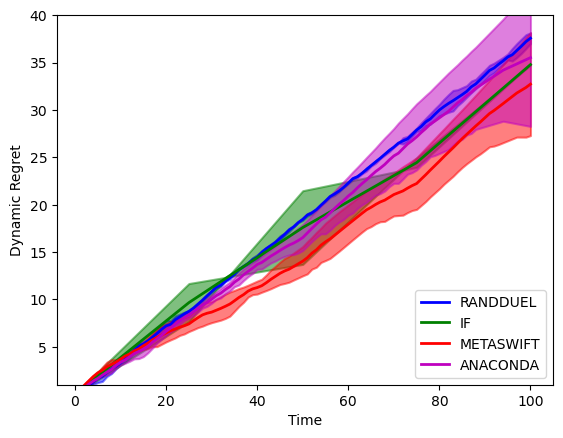

PyObject Text(24.000000000000007, 0.5, 'Dynamic Regret')

In [5]:
# plot results from saved data

# list of policies to plot
policies= [RANDDUEL,IF,METASWIFT,ANACONDA]
names=["RANDDUEL","IF","METASWIFT","ANACONDA"]

# experiment parameters
S=Episodes[1] # number of stationary phases
lP = length(policies) # number of policies 

df=DataFrame(Algo= String[],Regret=Float32[],Stdev=Float32[])
clf() # clear figure
figure()
colors=["b","g","r","m"]
# display results and plot the regret for each policy
PyPlot.ylim(top=(T*0.4))
PyPlot.ylim(bottom=1)
PyPlot.yscale("linear")
for imeth in 1:lP
    policy = policies[imeth]
    tsave=floor.(Int,collect(range(1,T,length=500)))
    Restarts = zeros(Int,N)
    Regret=zeros(N,length(tsave))
    for m in 1:N
        name = "results/$(series)_$(names[imeth])_T_$(T)_N_$(N)_S_$(S)/$(m)"
        Regret[m,:]=h5read(name,"Regret") # load regret
        Restarts[m] = h5read(name,"Restarts") # load restart points
    end
    # print summary of results
    regfinal = mean(Regret[:,end])
    stdevfinal = std(Regret[:,end])
    push!(df,("$(policy)",regfinal,stdevfinal))
    print("Mean final regret for $(policy) is $(regfinal) with std $(stdevfinal))\n")
    print("Mean number of restarts for $(policy) is $(mean(Restarts)) with std $(std(Restarts))\n")
	# plot regret
	PyPlot.plot(vec(tsave),vec(mean(Regret,dims=1)),linewidth=2,label="$(names[imeth])",color=colors[imeth])
    PyPlot.fill_between(vec(tsave),max(zeros(length(tsave)), vec(mean(Regret,dims=1).-std(Regret,dims=1))),
        vec(mean(Regret,dims=1).+std(Regret,dims=1)),
        alpha=.5,
        interpolate=true,
        color=colors[imeth],
        linewidth=1.5)
end

# plot labels and legends
legend(loc="lower right")
xlabel("Time")
ylabel("Dynamic Regret")


